<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Overlap_between_MEFs_and_EB_for_HDACs_HATs_Inflammatory_and_NFkB_genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Nikita Dsouza

The goal of this notebook id to examine the expression pattern of HATs, HDACs, Inflammatory related and NFkB related pathways in both ES/EB and MEF systems to see if the genes are upregulated or downregulated using a Treatment and control

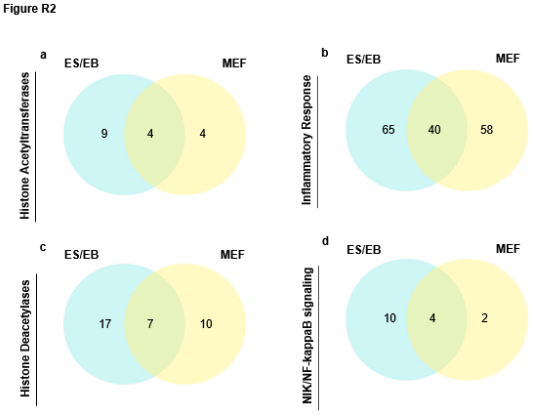

In [ ]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2','clusterProfiler','VennDiagram','fgsea','cowplot'
), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')
devtools::install_github("GSEA-MSigDB/GSEA_R")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'stringr' 'ggplot2'”
Installing package(s) 'BiocVersion', 'SummarizedExperiment', 'rhdf5',
  'SingleCellExperiment', 'limma', 'goseq',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db', 'wordcloud', 'plotrix',
  'DESeq2', 'clusterProfiler', 'VennDiagram', 'fgsea', 'cowplot'

also installing the dependencies ‘gridGraphics’, ‘Rhtslib’, ‘rjson’, ‘filelock’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘ggplotify’, ‘patchwork’, ‘lazyeval’, ‘zlibbioc’, ‘bitops’, ‘XML’, ‘Rsamtools’, ‘GenomicAlignments’, ‘restfulr’, ‘plogr’, ‘png’, ‘BiocFileCache’, ‘xtable’, ‘ggforce’, ‘ggrepel


✔  checking for file ‘/tmp/Rtmpr2j7zN/remotes4d5eb7d347/rstudio-reticulate-277f410/DESCRIPTION’
─  preparing ‘reticulate’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘reticulate_1.22-9000.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)





✔  checking for file ‘/tmp/Rtmpr2j7zN/remotes4d6f2363d1/GSEA-MSigDB-GSEA_R-8fbd326/DESCRIPTION’
─  preparing ‘GSEA’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘GSEA_1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Loading R libraries for the analysis

In [ ]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)
library(GSEA)
library(fgsea)
library(VennDiagram)
library(cowplot)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

# Loading the gene list obtained from GO containg 4 categories (Hats, HDACs, Inflammatory related and NFkB pathwway related)
https://www.ebi.ac.uk/QuickGO/annotations?goUsage=descendants&goUsageRelationships=is_a,part_of,occurs_in&goId=GO:0004402&taxonId=10090&taxonUsage=descendants

In [ ]:
gene_list <- c(
  "nfkb" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Nf_kB.tsv",
  "hdac" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/HDAC_complex.tsv",
  "hat" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Hat.tsv",
  "inflammatory" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Inflammatory_go.tsv")

In [ ]:
for (i in 1:length(gene_list)){
  sprintf('wget -x -c -nH %s', gene_list[i]) %>% system()
}
gene_list <- gsub('https://s3.msi.umn.edu/', './', gene_list)
message(sprintf('all gene_list exist: %s', all(file.exists(gene_list))))

all gene_list exist: TRUE



## Gene list for HDACs, HATs, Inflammatory and NFkB

In [ ]:
genes <- lapply(gene_list, function(g){read.table(g, header = TRUE, sep = '\t')})

In [ ]:
unique(genes[["hdac"]]$GO.NAME)

[1] "Swr1 complex"                "Sin3 complex"               
[3] "histone deacetylase complex" "NuRD complex"               
[5] "Sin3-type complex"

In [ ]:
genes[["hdac_sub"]] <- genes[["hdac"]][grepl('histone', genes[["hdac"]]$GO.NAME),] #Subsetting Histone Deactylase complex

In [ ]:
str(genes)

List of 5
 $ nfkb        :'data.frame':	55 obs. of  14 variables:
  ..$ GENE.PRODUCT.DB     : chr [1:55] "UniProtKB" "UniProtKB" "UniProtKB" "UniProtKB" ...
  ..$ GENE.PRODUCT.ID     : chr [1:55] "B1AUW6" "E9PUV9" "E9QNL4" "F8VQ54" ...
  ..$ SYMBOL              : chr [1:55] "Irak1" "Card10" "Chuk" "Dicer1" ...
  ..$ QUALIFIER           : chr [1:55] "involved_in" "involved_in" "involved_in" "involved_in" ...
  ..$ GO.TERM             : chr [1:55] "GO:0007250" "GO:0007250" "GO:0038061" "GO:0038061" ...
  ..$ GO.NAME             : chr [1:55] "activation of NF-kappaB-inducing kinase activity" "activation of NF-kappaB-inducing kinase activity" "NIK/NF-kappaB signaling" "NIK/NF-kappaB signaling" ...
  ..$ ECO.ID              : chr [1:55] "ECO:0000265" "ECO:0000265" "ECO:0000265" "ECO:0000265" ...
  ..$ GO.EVIDENCE.CODE    : chr [1:55] "IEA" "IEA" "IEA" "IEA" ...
  ..$ REFERENCE           : chr [1:55] "GO_REF:0000107" "GO_REF:0000107" "GO_REF:0000107" "GO_REF:0000107" ...
  ..$ WITH.FROM     

# scRNA seq

## Load processed scRNA-seq data

In [ ]:
se_file <- c(
  "se" = "https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")

In [ ]:
for (i in 1:length(se_file)){
  sprintf('wget -x -c -nH %s', se_file[i]) %>% system()
}
se_file <- gsub('https://s3.msi.umn.edu/', './', se_file)
message(sprintf('all se_file exist: %s', all(file.exists(se_file))))

all se_file exist: TRUE



In [ ]:
se <- se_file %>%
  readRDS()

In [ ]:
se

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

## Calculating Diferential expression for Treatment (MEF_Dox_D7b) vs Control (MEF_NoDox)

In [ ]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
control <- colData(se)$group == 'MEF_NoDox'
treatment <- colData(se)$group == 'MEF_Dox_D7b'
pvalues_tc <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, treatment], X[i, control], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc_tc <- rowMeans(assays(se)$normalized_counts[, treatment]+1)/rowMeans(assays(se)$normalized_counts[, control]+1)
names(pvalues_tc) <- names(fc_tc) <- rowData(se)$name

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



## Dataset containing Fold change and p values MEF D7 Flk1+ vs MEFs

In [ ]:
res_scrna <- data.frame(
  name = rowData(se)$name, 
  fc = fc_tc, 
  pvalue = pvalues_tc
)

In [ ]:
res_scrna$log2fc <- log2(fc_tc)

In [ ]:
head(res_scrna)

,name,fc,pvalue,log2fc
,<chr>,<dbl>,<dbl>,<dbl>
1,Mrpl15,0.8561015,1.588210e-40,-0.224146290
2,Lypla1,0.9869158,1.476162e-09,-0.019001027
3,Gm37988,0.9997660,4.958114e-01,-0.000337565
4,Tcea1,0.8246107,3.610119e-43,-0.278214927
5,Rgs20,0.9858808,2.354869e-05,-0.020514837
6,Atp6v1h,1.1638874,4.307872e-07,0.218951431


## Subsetting the genes as up-regulated, down-regulated for the treatment

In [ ]:
up <- res_scrna %>%
  filter(!is.na(pvalue) & log2fc > 0 & pvalue <0.05)

In [ ]:
down <- res_scrna %>%
  filter(!is.na(pvalue) & log2fc < 0 & pvalue < 0.05)

In [ ]:
dim(up)
dim(down)

[1] 3829    4

[1] 6944    4

## Subsetting genes for each of the 5 categories (Hats, HDACs, HDACs complex, Inflammatory related and NFkB pathwway related) in the up regulated and downregulated genes (treatment)

UP

In [ ]:
up_genes <- lapply(1:length(genes),function(x){up[up$name %in% genes[[x]]$SYMBOL,]})

In [ ]:
names(up_genes) <- names(genes)

In [ ]:
str(up_genes)

List of 5
 $ nfkb        :'data.frame':	6 obs. of  4 variables:
  ..$ name  : chr [1:6] "Ikbke" "Traf2" "Tlr4" "Relb" ...
  ..$ fc    : num [1:6] 1.04 1 1.06 1 1.03 ...
  ..$ pvalue: num [1:6] 2.20e-05 7.88e-04 4.46e-11 2.42e-02 3.90e-04 ...
  ..$ log2fc: num [1:6] 0.053 0.00593 0.08558 0.00684 0.04017 ...
 $ hdac        :'data.frame':	24 obs. of  4 variables:
  ..$ name  : chr [1:24] "Satb2" "Dnttip1" "Zfp217" "Hdac6" ...
  ..$ fc    : num [1:24] 1.01 1.02 1.11 1.01 1 ...
  ..$ pvalue: num [1:24] 1.31e-02 2.05e-04 5.68e-08 6.51e-03 1.14e-02 ...
  ..$ log2fc: num [1:24] 0.01685 0.02411 0.14849 0.01297 0.00481 ...
 $ hat         :'data.frame':	13 obs. of  4 variables:
  ..$ name  : chr [1:13] "Atf2" "Ncoa3" "Gtf2b" "Supt7l" ...
  ..$ fc    : num [1:13] 1.04 1.03 1.05 1.01 1.02 ...
  ..$ pvalue: num [1:13] 0.017125 0.017757 0.012629 0.008127 0.000104 ...
  ..$ log2fc: num [1:13] 0.0546 0.0445 0.0714 0.0127 0.0265 ...
 $ inflammatory:'data.frame':	105 obs. of  4 variables:
  ..$ name  : c

DOWN

In [ ]:
down_genes <- lapply(1:length(genes),function(x){down[down$name %in% genes[[x]]$SYMBOL,]})

In [ ]:
names(down_genes) <- names(genes)

In [ ]:
str(down_genes)

List of 5
 $ nfkb        :'data.frame':	16 obs. of  4 variables:
  ..$ name  : chr [1:16] "Cops8" "Traf6" "Irak1" "Ikbkg" ...
  ..$ fc    : num [1:16] 0.857 0.99 0.94 0.988 0.999 ...
  ..$ pvalue: num [1:16] 1.11e-40 5.22e-08 2.31e-23 5.50e-09 4.40e-09 ...
  ..$ log2fc: num [1:16] -0.22347 -0.01499 -0.08877 -0.01797 -0.00118 ...
 $ hdac        :'data.frame':	36 obs. of  4 variables:
  ..$ name  : chr [1:36] "Hdac4" "Csnk2a1" "Tbl1x" "Anp32e" ...
  ..$ fc    : num [1:36] 0.992 0.889 0.878 0.749 0.963 ...
  ..$ pvalue: num [1:36] 1.28e-08 5.03e-29 6.20e-28 1.11e-92 9.24e-13 ...
  ..$ log2fc: num [1:36] -0.0118 -0.1692 -0.1869 -0.4169 -0.0542 ...
 $ hat         :'data.frame':	21 obs. of  4 variables:
  ..$ name  : chr [1:21] "Gtf3c4" "Mettl8" "Hat1" "Kat14" ...
  ..$ fc    : num [1:21] 0.984 0.999 0.773 0.965 0.97 ...
  ..$ pvalue: num [1:21] 2.62e-11 1.16e-04 2.86e-94 2.46e-16 3.07e-13 ...
  ..$ log2fc: num [1:21] -0.02339 -0.00182 -0.37185 -0.0514 -0.04333 ...
 $ inflammatory:'data.fram

#RNAseq

## Load the bulk RNA-seq of Etv2 induction in ES/EB and calculating Differential expression of treatment (EB_Dox_D25_Flk1pos_Etv2) vs control (EB_NoDox_D25_Etv2)

In [ ]:
se_rna <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))
se_rna <- DESeqDataSet(se_rna, design = ~ group)
se_rna <- estimateSizeFactors(se_rna)
se_rna <- DESeq(se_rna)
table(colData(se_rna)$group)
res <- results(se_rna, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_rna, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




         EB_Dox_D2_Etv2         EB_Dox_D25_Etv2 EB_Dox_D25_Flk1pos_Etv2 
                      2                       2                       2 
       EB_NoDox_D2_Etv2       EB_NoDox_D25_Etv2 
                      2                       2 

In [ ]:
head(res)

log2 fold change (MLE): group EB_Dox_D25_Flk1pos_Etv2 vs EB_NoDox_D25_Etv2 
Wald test p-value: group EB_Dox_D25_Flk1pos_Etv2 vs EB_NoDox_D25_Etv2 
DataFrame with 6 rows and 6 columns
               baseMean log2FoldChange     lfcSE       stat      pvalue
              <numeric>      <numeric> <numeric>  <numeric>   <numeric>
0610005C13Rik   22.5079      2.2176660  0.749898  2.9572892 0.003103568
0610007C21Rik  317.4460      0.3328445  0.226857  1.4671992 0.142321886
0610007L01Rik 2692.5195     -0.3353582  0.101905 -3.2909007 0.000998672
0610007N19Rik   78.4967     -0.0255568  0.346032 -0.0738567 0.941124427
0610007P08Rik 1393.9053      0.0461691  0.121432  0.3802055 0.703792879
0610007P14Rik 1402.6347     -0.0875989  0.137903 -0.6352198 0.525285091
                    padj
               <numeric>
0610005C13Rik 0.00845671
0610007C21Rik 0.23300793
0610007L01Rik 0.00302910
0610007N19Rik 0.97192676
0610007P08Rik 0.79528900
0610007P14Rik 0.64609835

## Subsetting the genes as up-regulated, down-regulated for the treatment

In [ ]:
up_rna <- as.data.frame(res) %>%
  filter(pvalue < 0.05 & log2FoldChange > 0)

In [ ]:
down_rna <- as.data.frame(res) %>%
  filter(pvalue < 0.05 & log2FoldChange < 0)

In [ ]:
dim(up_rna)
dim(down_rna)

[1] 4365    6

[1] 4277    6

## Subsetting genes for each of the 5 categories (Hats, HDACs, HDACs complex, Inflammatory related and NFkB pathwway related) in the up regulated and downregulated genes (treatment)

In [ ]:
up_rna_genes <- lapply(1:length(genes),function(x){up_rna[rownames(up_rna) %in% genes[[x]]$SYMBOL,]})
names(up_rna_genes) <- names(genes)

In [ ]:
str(up_rna_genes)

List of 5
 $ nfkb        :'data.frame':	14 obs. of  6 variables:
  ..$ baseMean      : num [1:14] 3045.9 985 1768.1 5287.3 18.4 ...
  ..$ log2FoldChange: num [1:14] 0.714 1.06 0.241 0.273 2.632 ...
  ..$ lfcSE         : num [1:14] 0.106 0.146 0.107 0.121 0.794 ...
  ..$ stat          : num [1:14] 6.71 7.26 2.24 2.26 3.31 ...
  ..$ pvalue        : num [1:14] 1.97e-11 3.92e-13 2.49e-02 2.36e-02 9.22e-04 ...
  ..$ padj          : num [1:14] 1.74e-10 4.03e-12 5.34e-02 5.09e-02 2.82e-03 ...
 $ hdac        :'data.frame':	17 obs. of  6 variables:
  ..$ baseMean      : num [1:17] 5179 779 717 327 2715 ...
  ..$ log2FoldChange: num [1:17] 0.387 0.564 0.407 1.021 0.291 ...
  ..$ lfcSE         : num [1:17] 0.113 0.128 0.146 0.174 0.101 ...
  ..$ stat          : num [1:17] 3.41 4.41 2.78 5.85 2.88 ...
  ..$ pvalue        : num [1:17] 6.42e-04 1.06e-05 5.44e-03 4.79e-09 3.99e-03 ...
  ..$ padj          : num [1:17] 2.02e-03 4.58e-05 1.39e-02 3.28e-08 1.06e-02 ...
 $ hat         :'data.frame':	8 obs

In [ ]:
down_rna_genes <- lapply(1:length(genes),function(x){down_rna[rownames(down_rna) %in% genes[[x]]$SYMBOL,]})
names(down_rna_genes) <- names(genes)

# Common up and down regulated genes in treatment between ES/EB (blue) and MEF(yellow)

## HAT's

UP_HATs

(polygon[GRID.polygon.11], polygon[GRID.polygon.12], polygon[GRID.polygon.13], polygon[GRID.polygon.14], text[GRID.text.15], text[GRID.text.16], text[GRID.text.17], text[GRID.text.18], text[GRID.text.19]) 

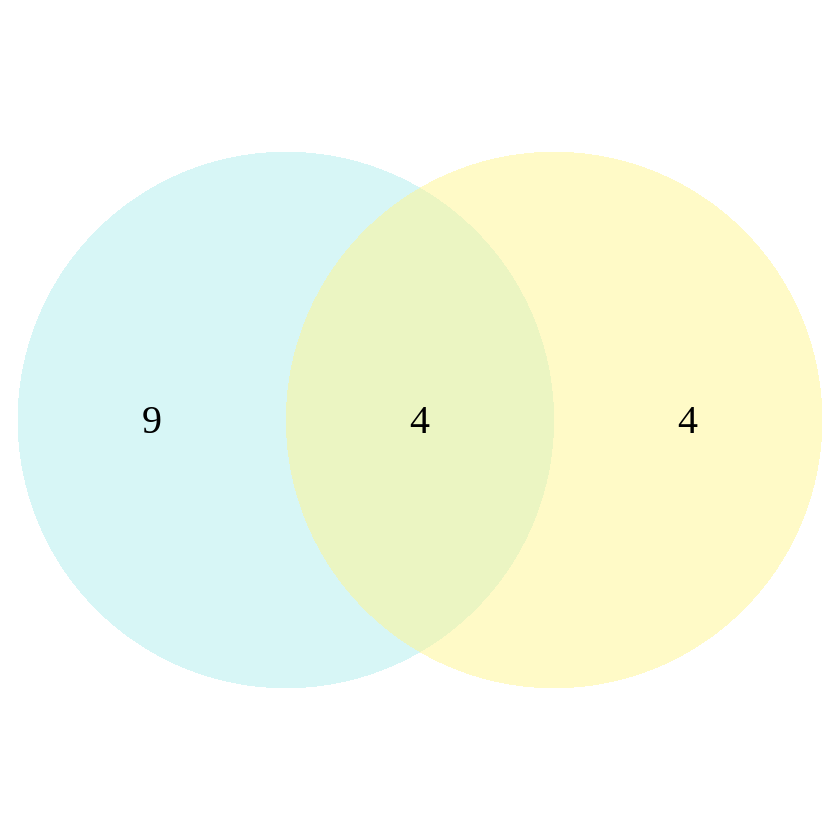

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(up_genes[['hat']]$name),
  area2 = length(rownames(up_rna_genes[['hat']])),
  cross.area = length(intersect(rownames(up_rna_genes[['hat']]), up_genes[['hat']]$name)),
  lty = "blank", 
  scaled = FALSE,
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1
)

DOWN_HATs

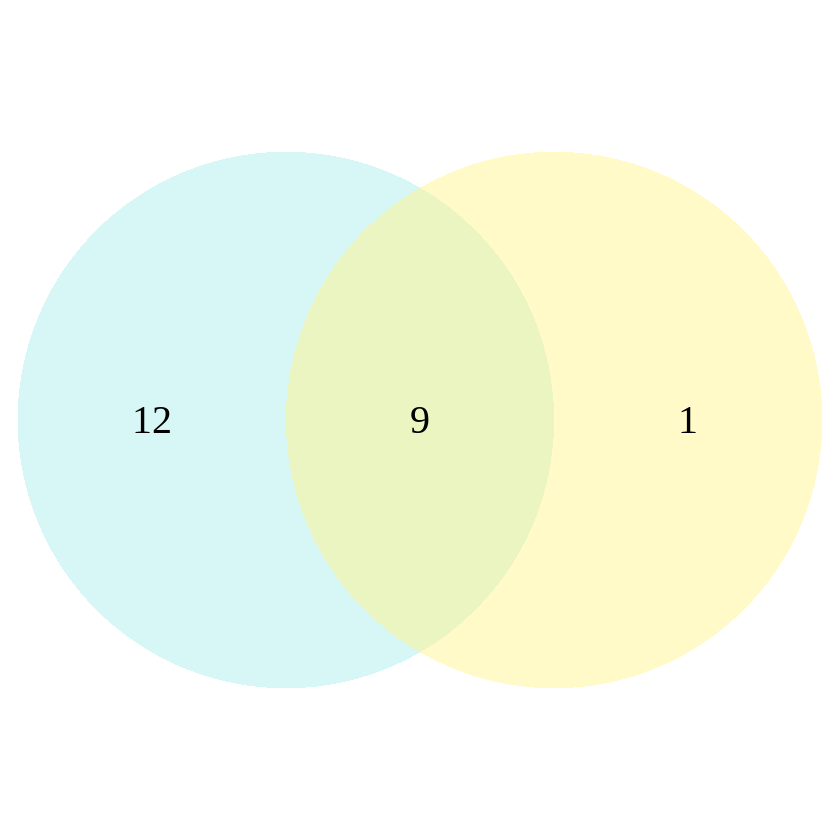

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
venn <- draw.pairwise.venn(
  area1 = length(down_genes[['hat']]$name),
  area2 = length(rownames(down_rna_genes[['hat']])),
  cross.area = length(intersect(rownames(down_rna_genes[['hat']]), down_genes[['hat']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  scaled = FALSE,
  cat.cex = 1
)

## HDAC

UP_HDACs

(polygon[GRID.polygon.29], polygon[GRID.polygon.30], polygon[GRID.polygon.31], polygon[GRID.polygon.32], text[GRID.text.33], text[GRID.text.34], text[GRID.text.35], text[GRID.text.36], text[GRID.text.37]) 

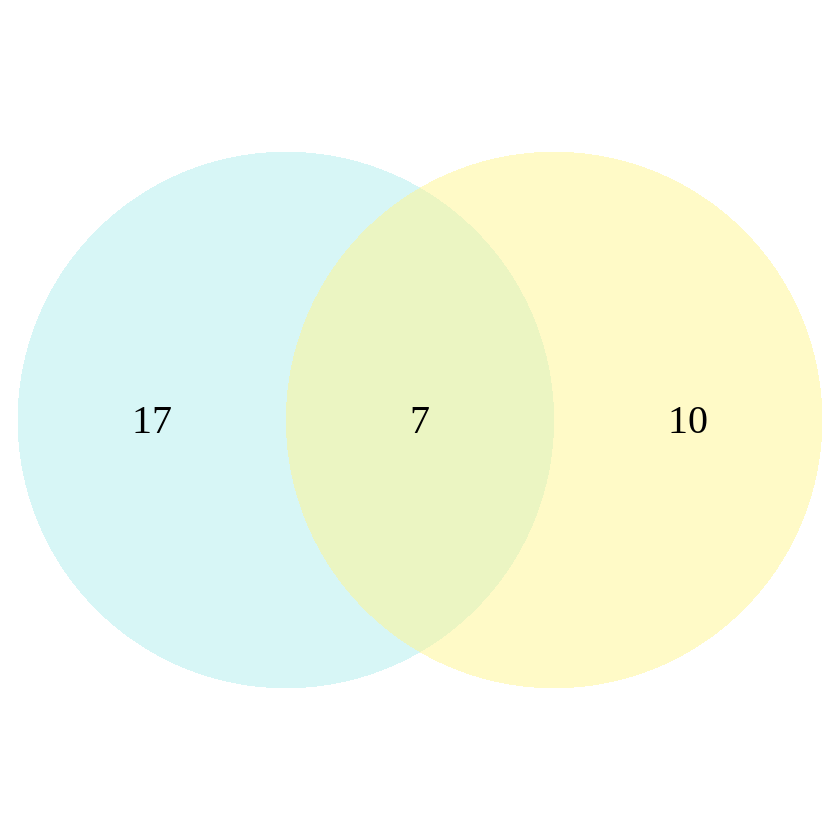

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(up_genes[['hdac']]$name),
  area2 = length(rownames(up_rna_genes[['hdac']])),
  cross.area = length(intersect(rownames(up_rna_genes[['hdac']]), up_genes[['hdac']]$name)), 
  lty = "blank",
  scaled = FALSE, 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1)

UP_HDACs_only_histonedeacytelase complex

(polygon[GRID.polygon.38], polygon[GRID.polygon.39], polygon[GRID.polygon.40], polygon[GRID.polygon.41], text[GRID.text.42], text[GRID.text.43], text[GRID.text.44], text[GRID.text.45], text[GRID.text.46]) 

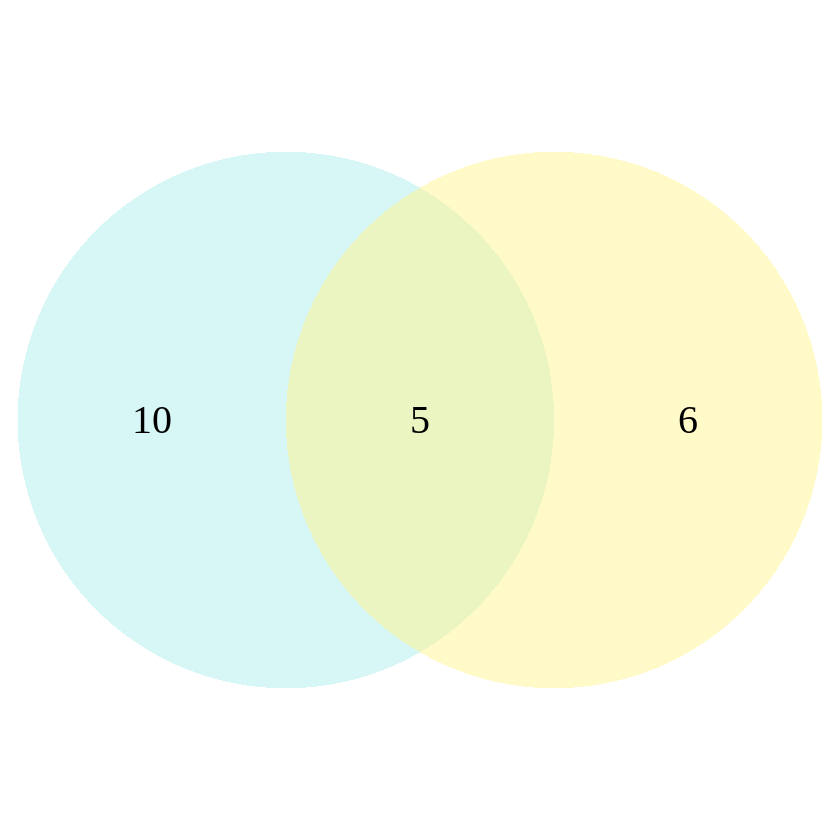

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(up_genes[['hdac_sub']]$name),
  area2 = length(rownames(up_rna_genes[['hdac_sub']])),
  cross.area = length(intersect(rownames(up_rna_genes[['hdac_sub']]), up_genes[['hdac_sub']]$name)), 
  lty = "blank", 
  scaled = FALSE,
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1)

DOWN_HDACs

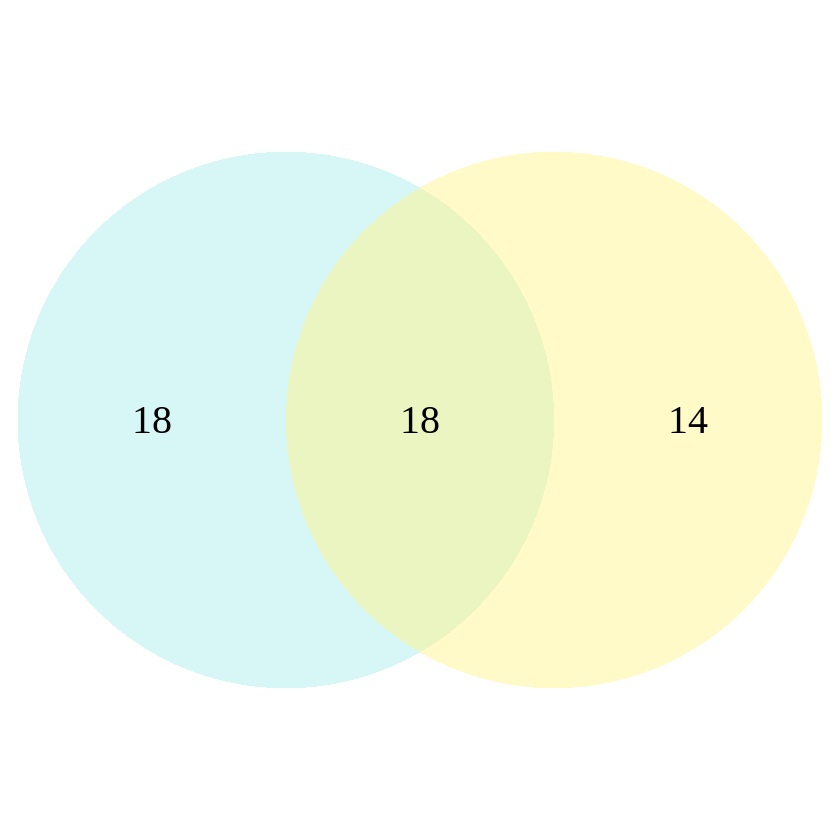

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
venn <- draw.pairwise.venn(
  area1 = length(down_genes[['hdac']]$name),
  area2 = length(rownames(down_rna_genes[['hdac']])),
  cross.area = length(intersect(rownames(down_rna_genes[['hdac']]), down_genes[['hdac']]$name)), 
  lty = "blank", 
  scaled = FALSE,
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1
)

DOWN_HDACs_only_histonedeacytelase complex

(polygon[GRID.polygon.56], polygon[GRID.polygon.57], polygon[GRID.polygon.58], polygon[GRID.polygon.59], text[GRID.text.60], text[GRID.text.61], text[GRID.text.62], text[GRID.text.63], text[GRID.text.64]) 

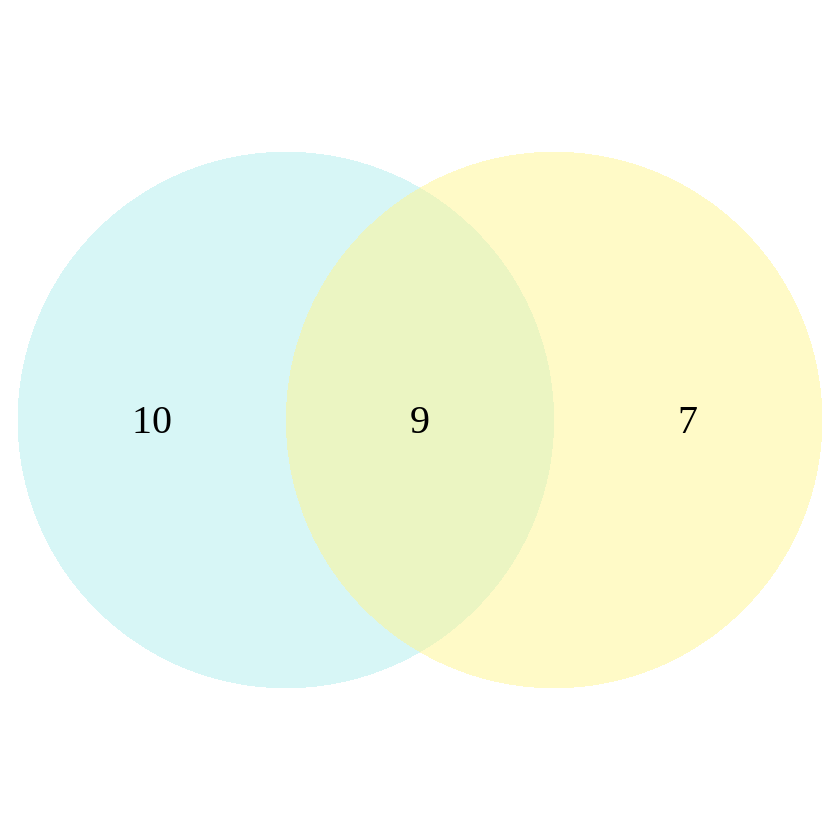

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(down_genes[['hdac_sub']]$name),
  area2 = length(rownames(down_rna_genes[['hdac_sub']])),
  cross.area = length(intersect(rownames(down_rna_genes[['hdac_sub']]), down_genes[['hdac_sub']]$name)), 
  lty = "blank", 
  scaled = FALSE,
  fill =  c( "khaki1","paleturquoise"),
  cex = 2,
  cat.cex = 1)


## Inflammatory

UP_Inflammatory

(polygon[GRID.polygon.65], polygon[GRID.polygon.66], polygon[GRID.polygon.67], polygon[GRID.polygon.68], text[GRID.text.69], text[GRID.text.70], text[GRID.text.71], text[GRID.text.72], text[GRID.text.73]) 

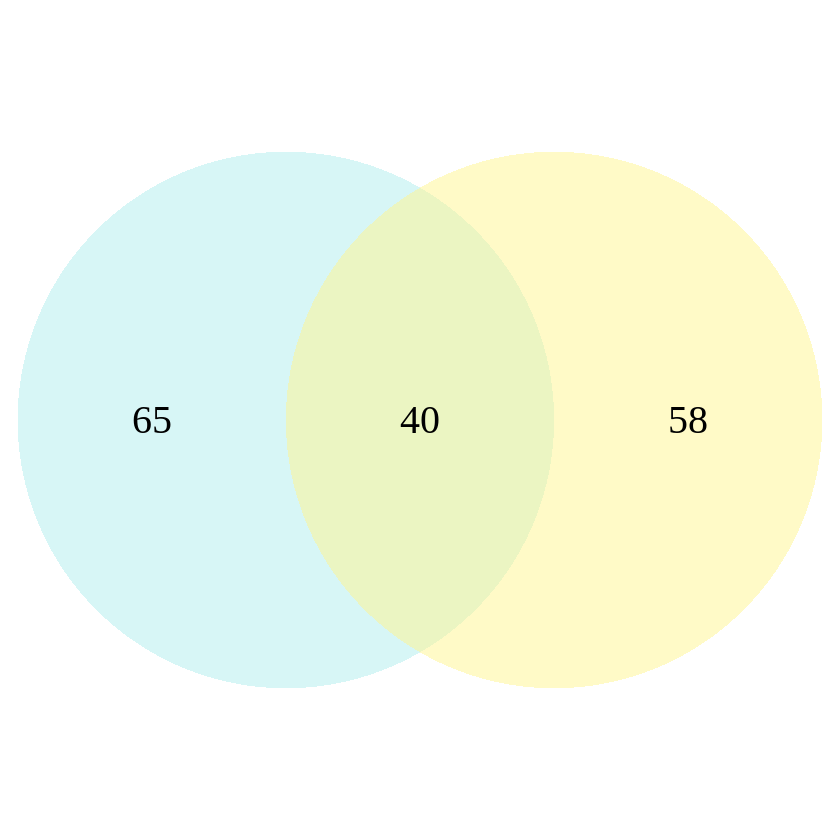

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(up_genes[['inflammatory']]$name),
  area2 = length(rownames(up_rna_genes[['inflammatory']])),
  cross.area = length(intersect(rownames(up_rna_genes[['inflammatory']]), up_genes[['inflammatory']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  scaled = FALSE,
  cat.cex = 1)

DOWN_Inflammatory

(polygon[GRID.polygon.74], polygon[GRID.polygon.75], polygon[GRID.polygon.76], polygon[GRID.polygon.77], text[GRID.text.78], text[GRID.text.79], text[GRID.text.80], text[GRID.text.81], text[GRID.text.82]) 

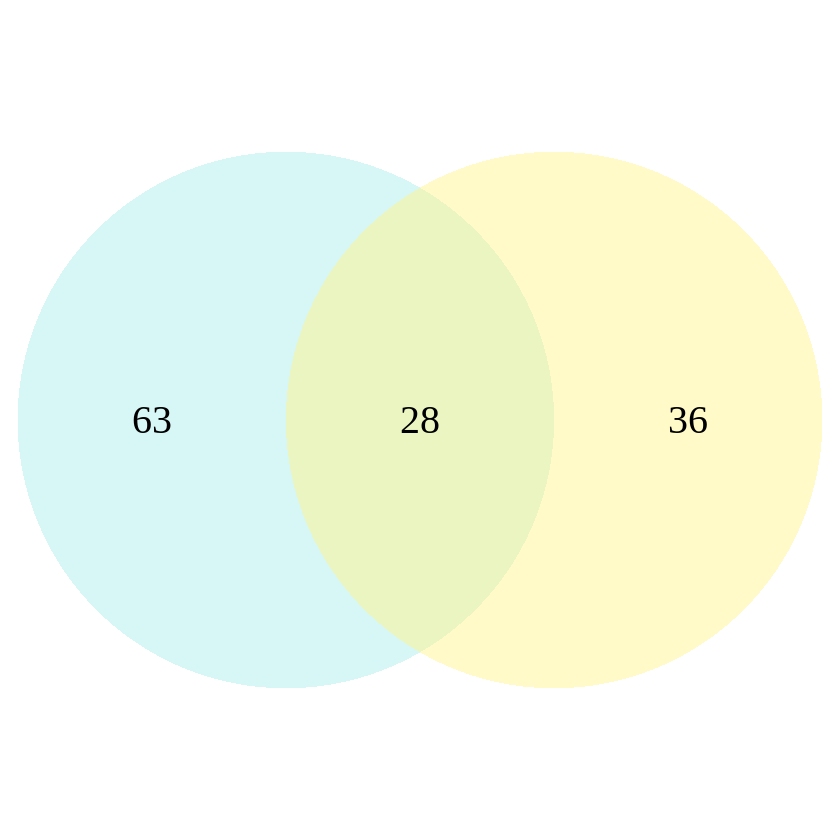

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(down_genes[['inflammatory']]$name),
  area2 = length(rownames(down_rna_genes[['inflammatory']])),
  cross.area = length(intersect(rownames(down_rna_genes[['inflammatory']]), down_genes[['inflammatory']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  scaled = FALSE,
  cat.cex = 1)

## NFkB

UP_NFkB

(polygon[GRID.polygon.83], polygon[GRID.polygon.84], polygon[GRID.polygon.85], polygon[GRID.polygon.86], text[GRID.text.87], text[GRID.text.88], text[GRID.text.89], text[GRID.text.90], text[GRID.text.91]) 

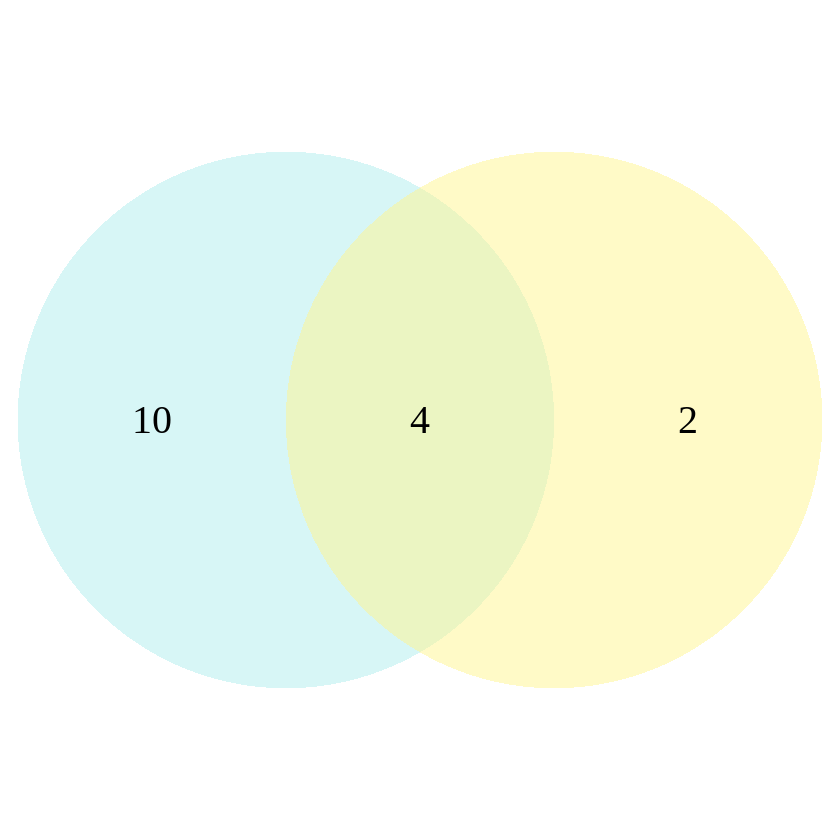

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(up_genes[['nfkb']]$name),
  area2 = length(rownames(up_rna_genes[['nfkb']])),
  cross.area = length(intersect(rownames(up_rna_genes[['nfkb']]), up_genes[['nfkb']]$name)), 
  lty = "blank", 
  fill = c( "khaki1","paleturquoise"),
  cex = 2,
  scaled = FALSE,
  cat.cex = 1)

DOWN_NFkB

(polygon[GRID.polygon.92], polygon[GRID.polygon.93], polygon[GRID.polygon.94], polygon[GRID.polygon.95], text[GRID.text.96], text[GRID.text.97], text[GRID.text.98], text[GRID.text.99], text[GRID.text.100]) 

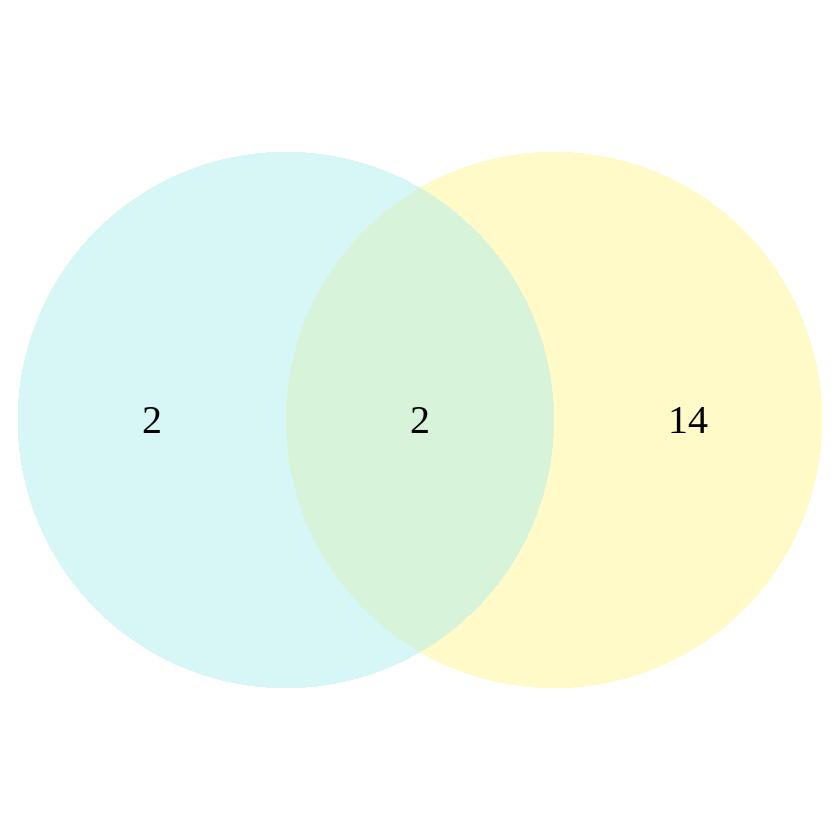

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(down_genes[['nfkb']]$name),
  area2 = length(rownames(down_rna_genes[['nfkb']]))+2,
  cross.area = length(intersect(rownames(down_rna_genes[['nfkb']]), down_genes[['nfkb']]$name)), 
  scaled = FALSE,
  euler.d = FALSE,
  lty = "blank",
  rotation.degree = 180, 
  fill =  c( "khaki1","paleturquoise"),
  cex = 2,
  cat.cex = 1)

In [ ]:
Sys.time() - start_time0

Time difference of 31.50395 mins

In [ ]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1                            
 [2] VennDiagram_1.6.20                       
 [3] futile.logger_1.4.3                      
 [4] fgsea_1.18.0                             
 [5] GSEA_1.2                                 